In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 25.7 MB/s 


In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math, gc, warnings, scipy, random, os, cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
%matplotlib inline

warnings.filterwarnings('ignore')

EPOCHS = 200
BATCH_SIZE = 32
IMG_SIZE = (208, 176)
SEED = 100
CLASSES = 4
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98
num_classes = 4
input_shape = (208, 176, 3)
image_size = 256
batch_size = 128
num_epochs = 100
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train2/ModerateDemented/moderateDem0.jpg")

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    }),
    total_num_examples=13174,
    splits={
        'test': 1279,
        'train': 5329,
        'train2': 6566,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



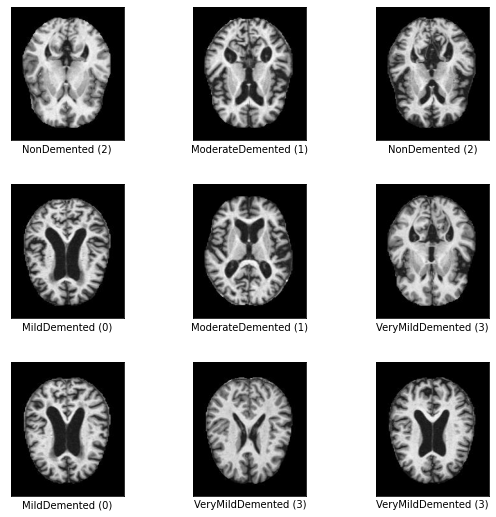

In [ ]:
builder = tfds.folder_dataset.ImageFolder("drive/MyDrive/CV/Alzheimer_Dataset/")
print(builder.info)  
ds_info = builder.info
ds_train = builder.as_dataset(split='train2', shuffle_files=True, as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds_train, builder.info)

In [ ]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # print(image)
    image = tf.cast(image, tf.float32) / 255.
    
    return 2*(image - 0.5), tf.one_hot(label, depth = 4)
    
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        y_true_K = tf.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

# Custom VGG

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

def VGG16(inp_shape = input_shape, 
          activation_fn = tf.nn.leaky_relu, 
          output_classes = 4):
    inp = tf.keras.layers.Input(inp_shape)
    aug_data = data_augmentation(inp)

    conv1  = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation = activation_fn)(aug_data)
    conv2  = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation = activation_fn)(conv1)
    pool1  = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3  = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation = activation_fn)(pool1)
    conv4  = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation = activation_fn)(conv3)
    pool2  = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    conv5  = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation = activation_fn)(pool2)
    conv6  = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation = activation_fn)(conv5)
    conv7  = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation = activation_fn)(conv6)
    pool3  = tf.keras.layers.MaxPooling2D((2, 2))(conv7)

    conv8  = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(pool3)
    conv9  = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(conv8)
    conv10 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(conv9)
    pool4  = tf.keras.layers.MaxPooling2D((2, 2))(conv10)

    conv11 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(pool4)
    conv12 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(conv11)
    conv13 = tf.keras.layers.Conv2D(512, kernel_size=(3,3), padding="same", activation = activation_fn)(conv12)
    pool5  = tf.keras.layers.MaxPooling2D((2, 2))(conv13)

    flat   = tf.keras.layers.Flatten()(pool5)
    dense1 = tf.keras.layers.Dense(4096, activation = activation_fn)(flat)
    dense2 = tf.keras.layers.Dense(4096, activation = activation_fn)(dense1)
    dense3 = tf.keras.layers.Dense(1000, activation = activation_fn)(dense2)
    output = tf.keras.layers.Dense(output_classes, activation="softmax")(dense3)

    model  = tf.keras.models.Model(inputs=inp, outputs=output)
    return model

vgg_model = VGG16()
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      7         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
vgg_model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(name="Cat_accuracy")] 
)

history = vgg_model.fit(ds_train,
    batch_size=batch_size,
    epochs=100,
    verbose=2,
    validation_data=ds_test
)

accuracy = vgg_model.evaluate(ds_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
vgg_model.save("/content/drive/MyDrive/CV/mymodel_vgg")

Epoch 1/100
206/206 - 554s - loss: 1.2285 - Cat_accuracy: 0.4182 - val_loss: 1.1751 - val_Cat_accuracy: 0.5066 - 554s/epoch - 3s/step
Epoch 2/100
206/206 - 63s - loss: 0.9771 - Cat_accuracy: 0.5183 - val_loss: 1.2740 - val_Cat_accuracy: 0.4386 - 63s/epoch - 304ms/step
Epoch 3/100
206/206 - 63s - loss: 0.8537 - Cat_accuracy: 0.5751 - val_loss: 1.0053 - val_Cat_accuracy: 0.5590 - 63s/epoch - 304ms/step
Epoch 4/100
206/206 - 63s - loss: 0.7755 - Cat_accuracy: 0.6090 - val_loss: 1.2769 - val_Cat_accuracy: 0.5043 - 63s/epoch - 304ms/step
Epoch 5/100
206/206 - 63s - loss: 0.7144 - Cat_accuracy: 0.6538 - val_loss: 1.2869 - val_Cat_accuracy: 0.5098 - 63s/epoch - 304ms/step
Epoch 6/100
206/206 - 63s - loss: 0.6710 - Cat_accuracy: 0.6799 - val_loss: 1.0370 - val_Cat_accuracy: 0.5872 - 63s/epoch - 304ms/step
Epoch 7/100
206/206 - 63s - loss: 0.6018 - Cat_accuracy: 0.7179 - val_loss: 0.9194 - val_Cat_accuracy: 0.6013 - 63s/epoch - 304ms/step
Epoch 8/100
206/206 - 63s - loss: 0.5531 - Cat_accuracy:

KeyboardInterrupt: ignored

In [ ]:
vgg_model.fit(ds_train,
    batch_size=batch_size,
    epochs=1,
    verbose=2,
    validation_data=ds_test
)

206/206 - 63s - loss: 0.0510 - Cat_accuracy: 0.9832 - val_loss: 1.5493 - val_Cat_accuracy: 0.7459 - 63s/epoch - 304ms/step


In [ ]:
_, accuracy = vgg_model.evaluate(ds_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
vgg_model.save("/content/drive/MyDrive/CV/mymodel_vgg")

40/40 [==============================] - 4s 95ms/step - loss: 1.5493 - Cat_accuracy: 0.7459
Test accuracy: 74.59%
INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV/mymodel_vgg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV/mymodel_vgg/assets


In [6]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/CV/mymodel_vgg")

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 176, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      7         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

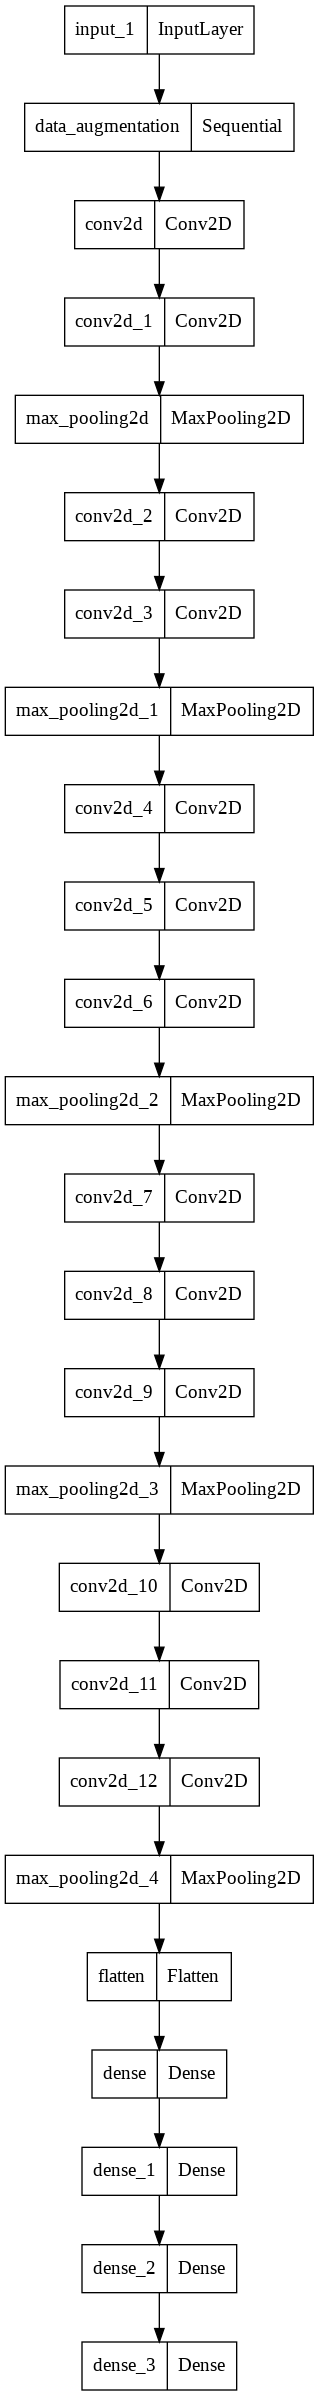

In [ ]:
tf.keras.utils.plot_model(new_model)

In [7]:
idxs = []
for idx,i in enumerate(new_model.layers):
    if "conv" in i.name:
        idxs.append(idx)
idxs

[2, 3, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]

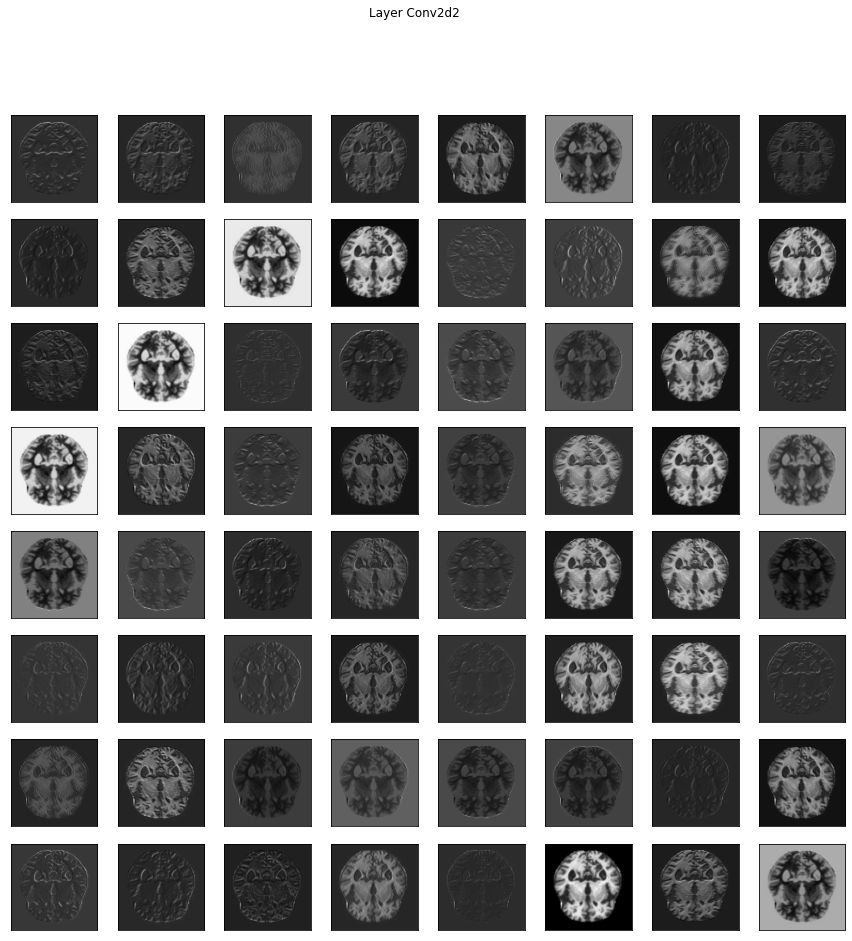

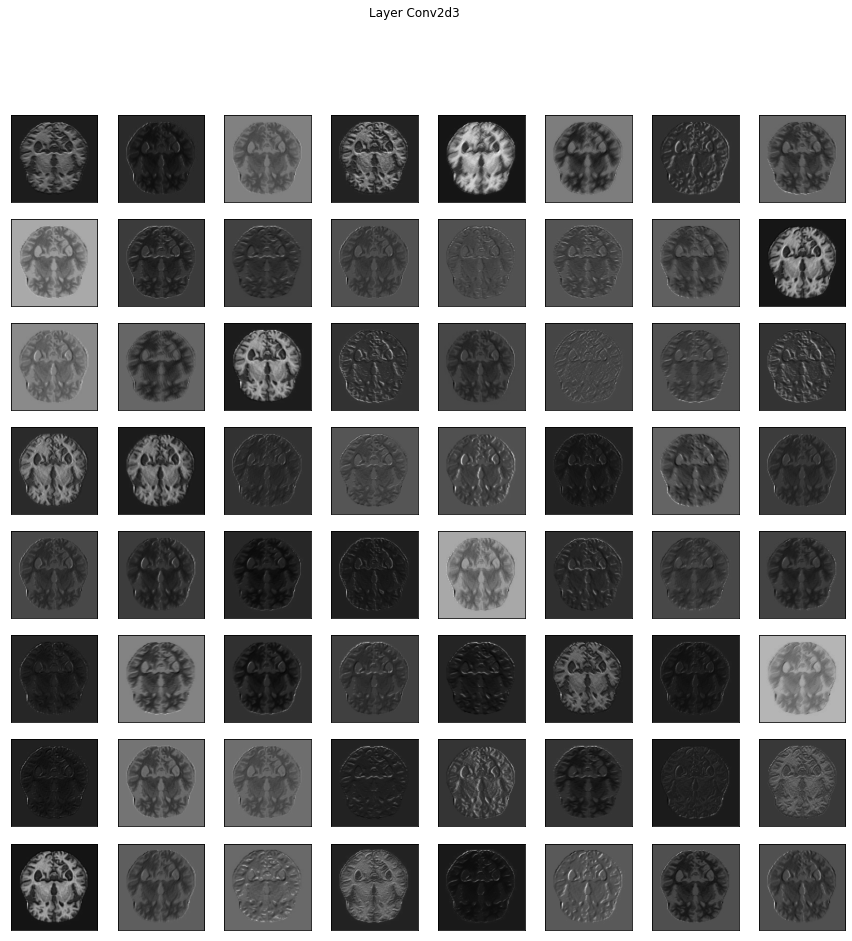

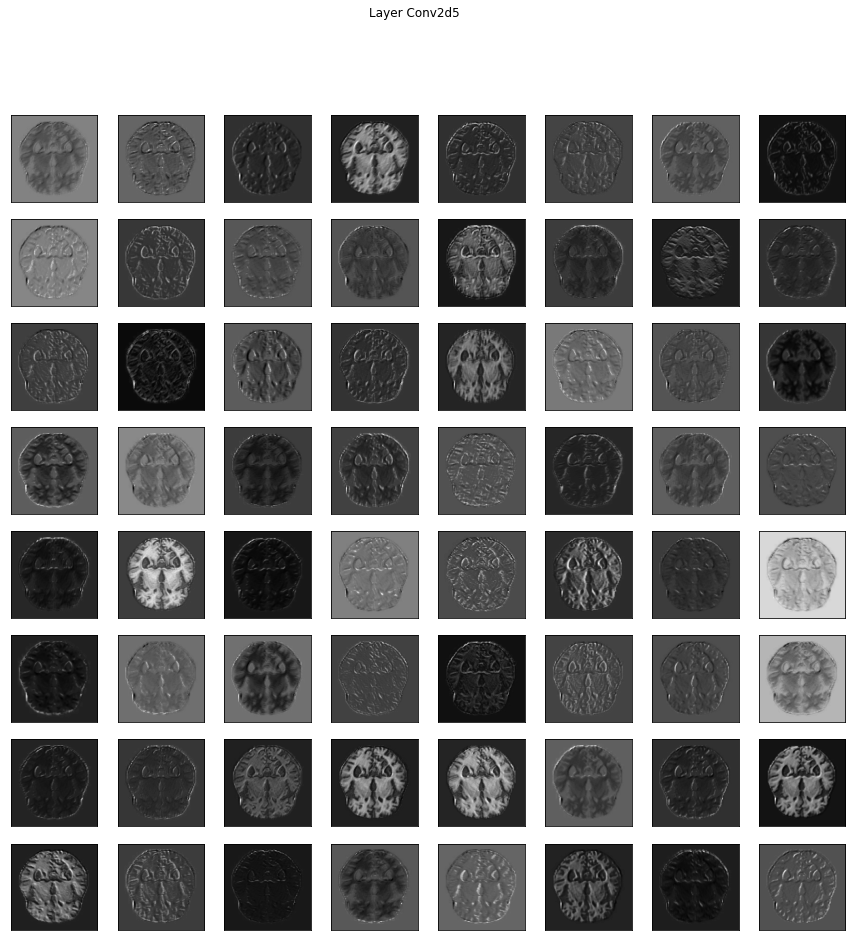

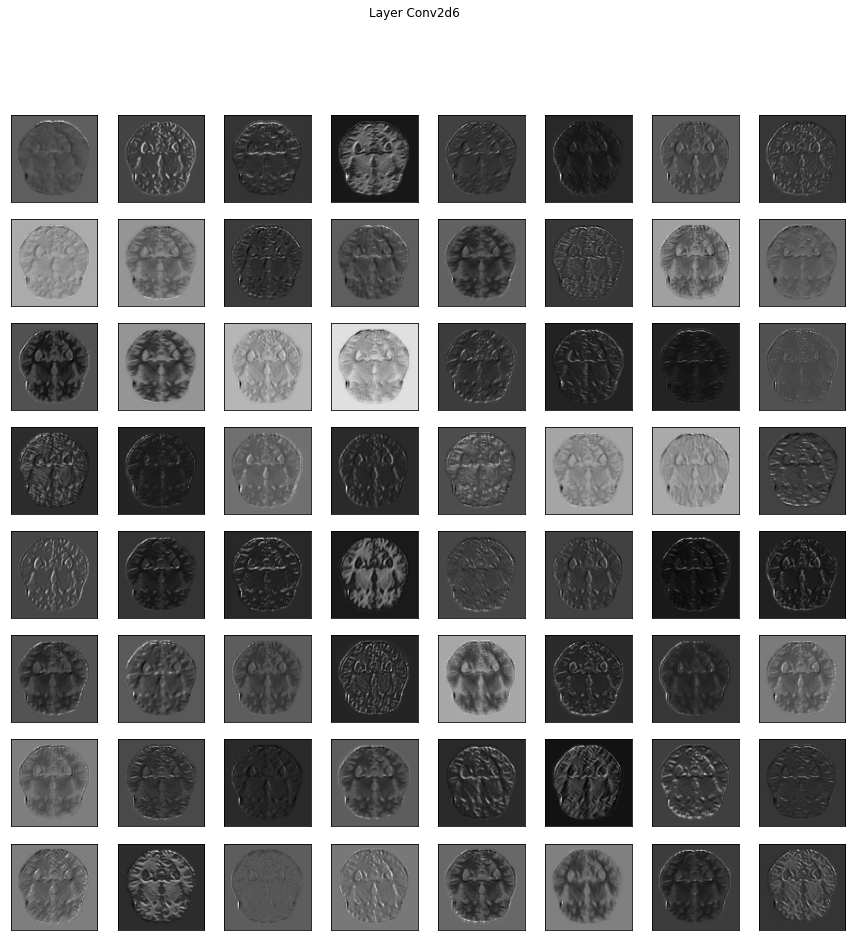

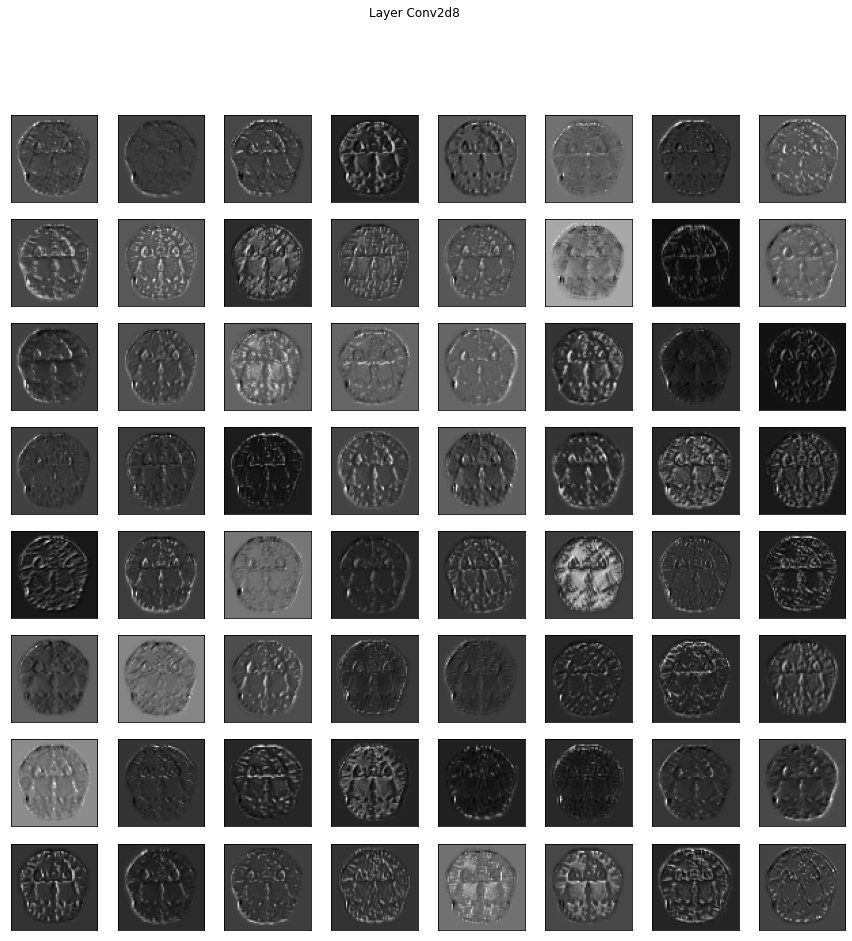

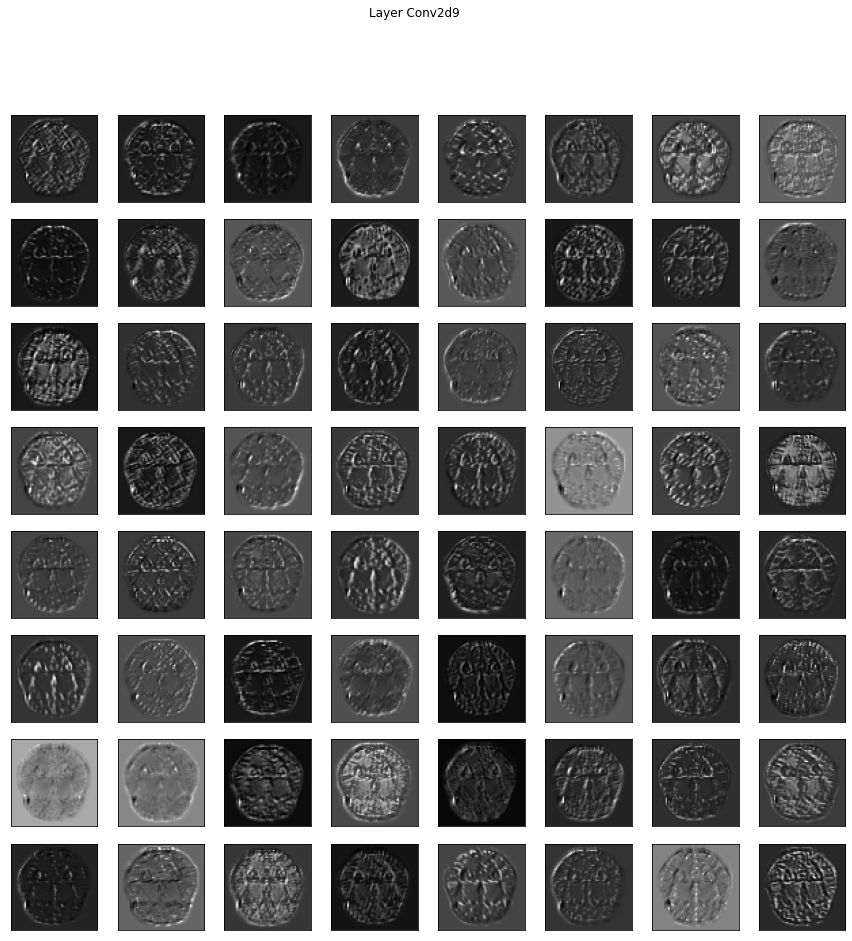

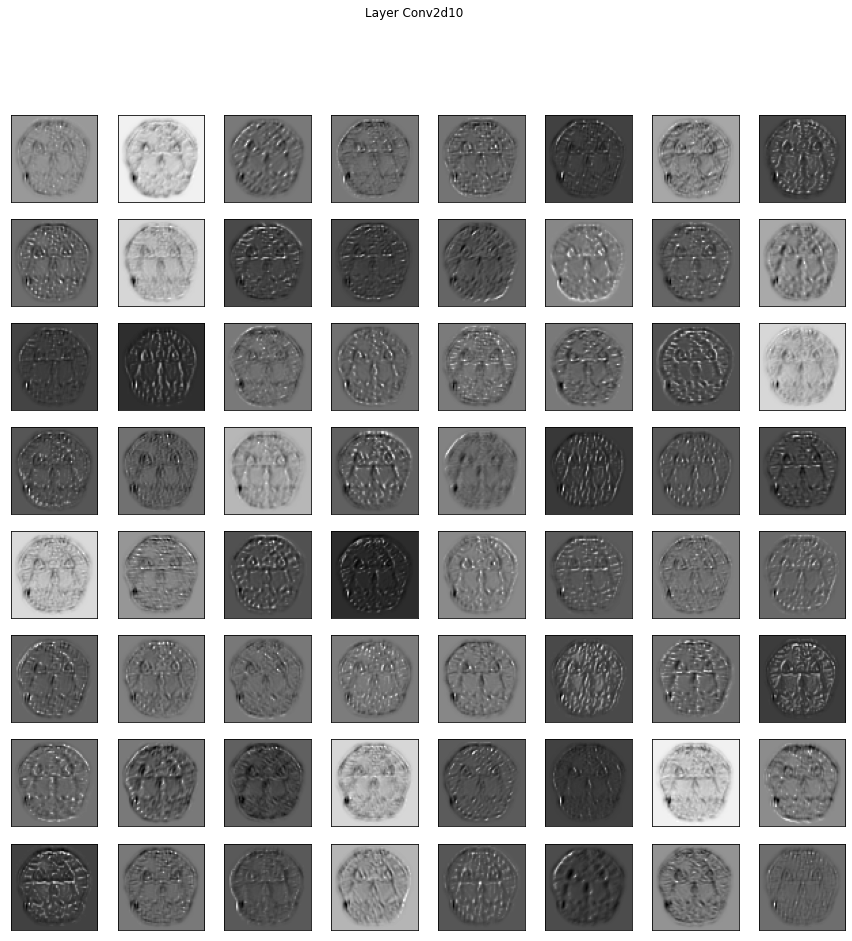

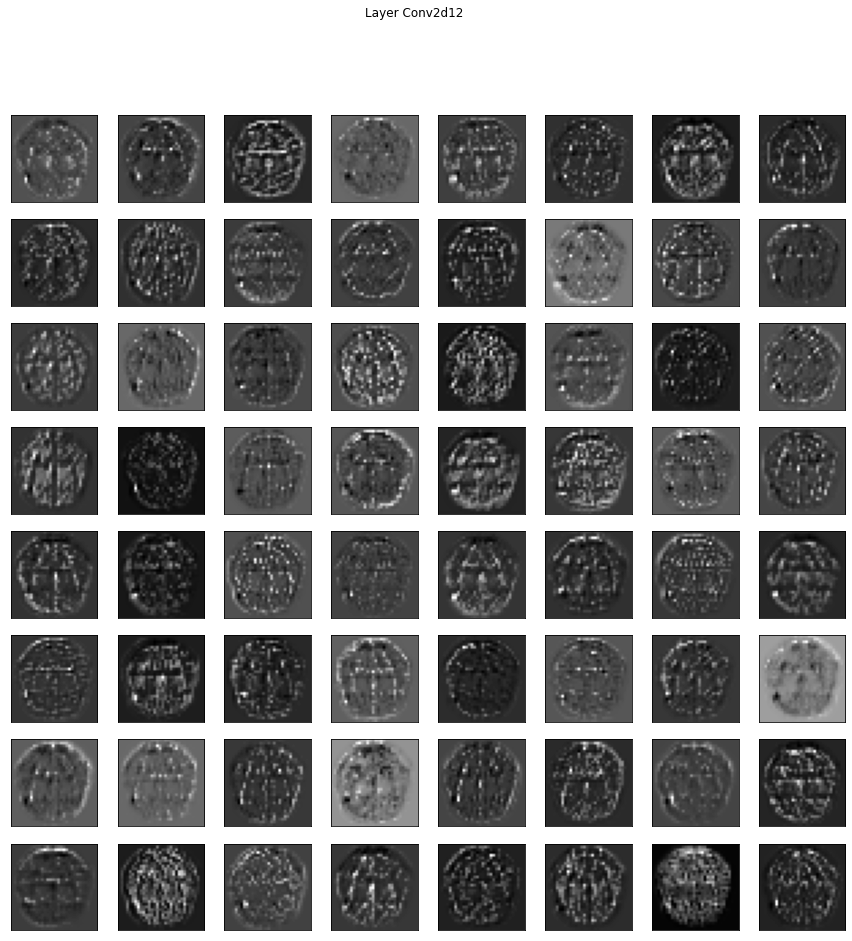

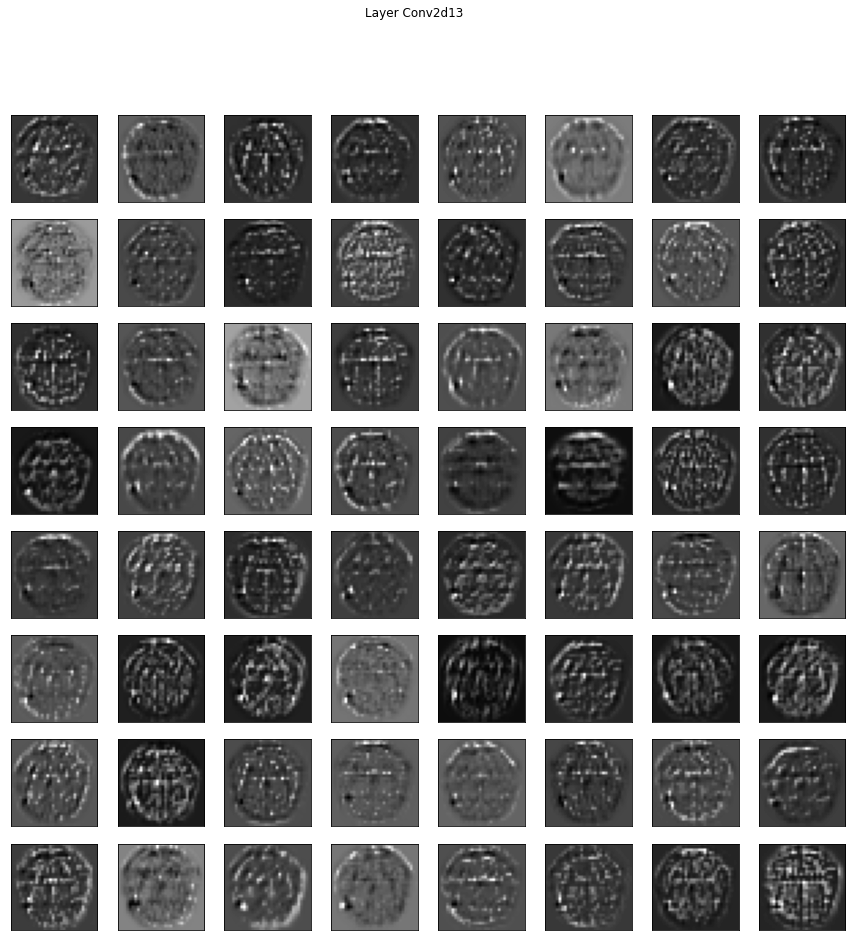

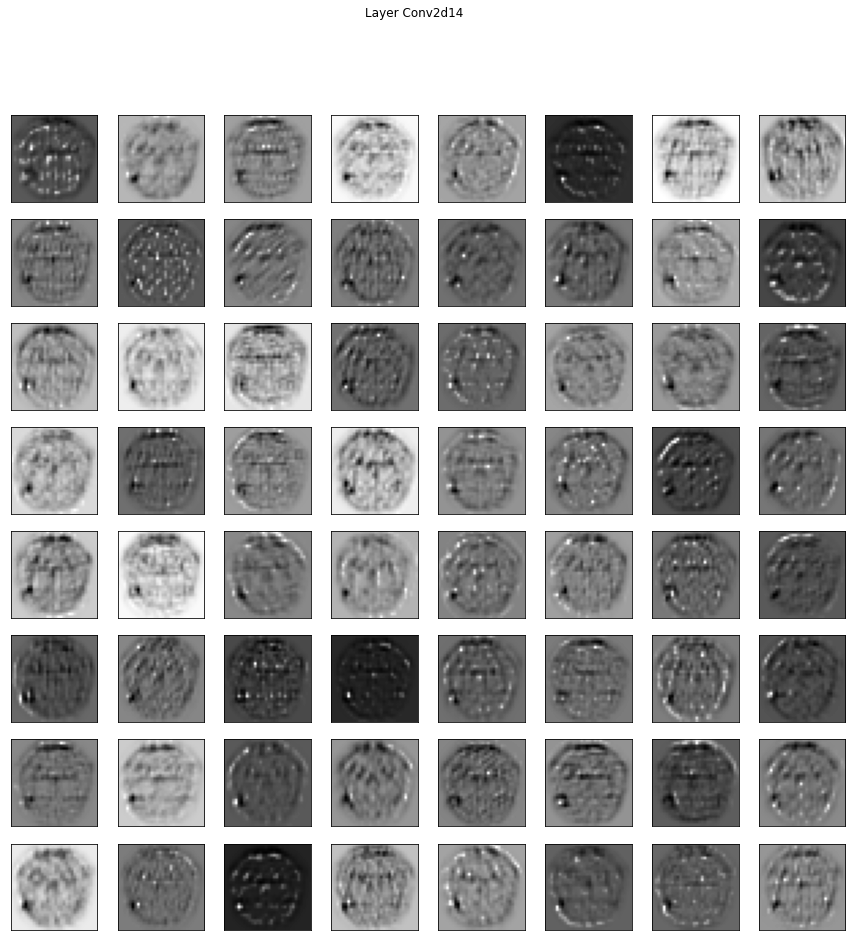

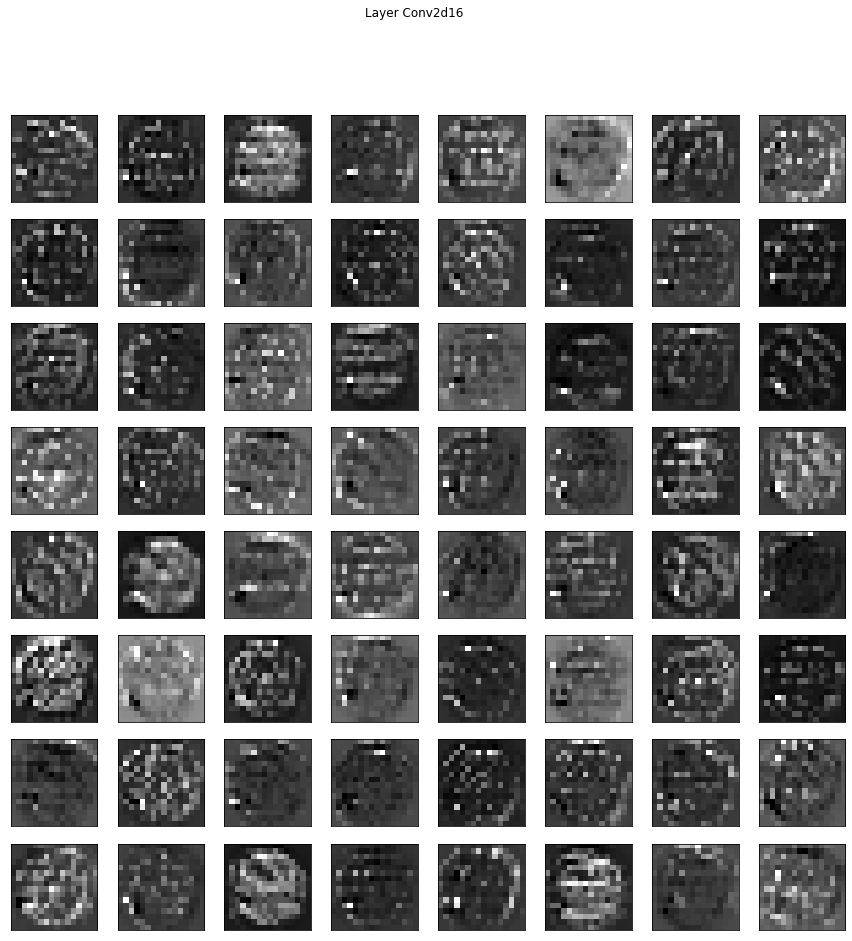

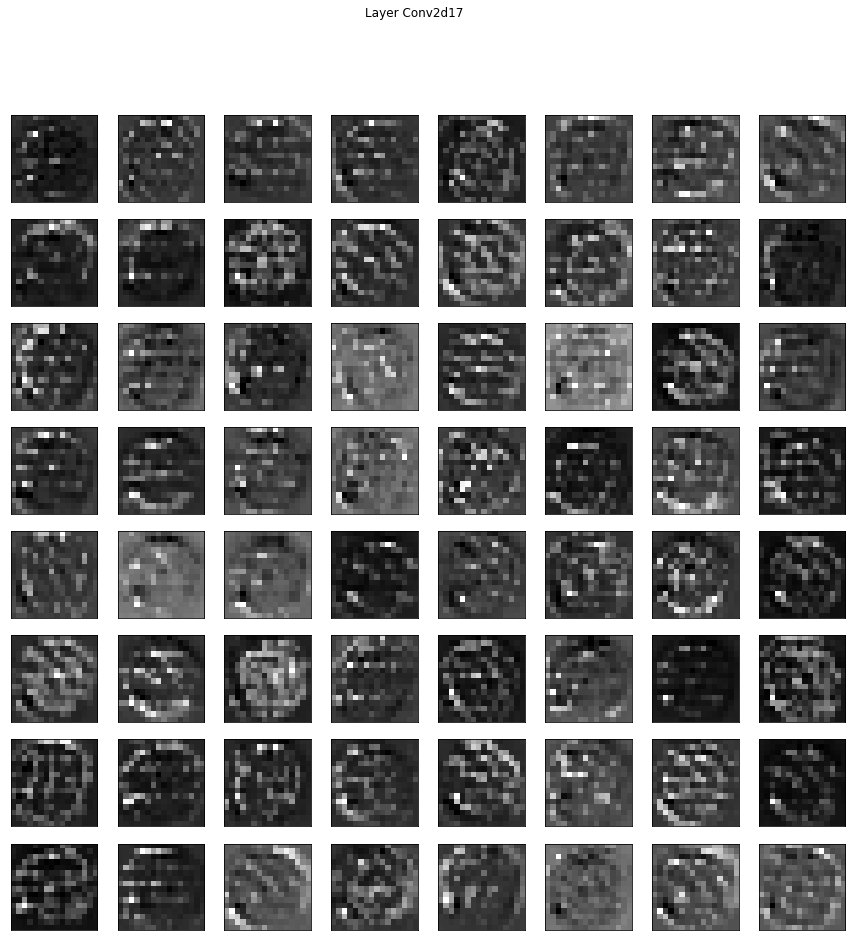

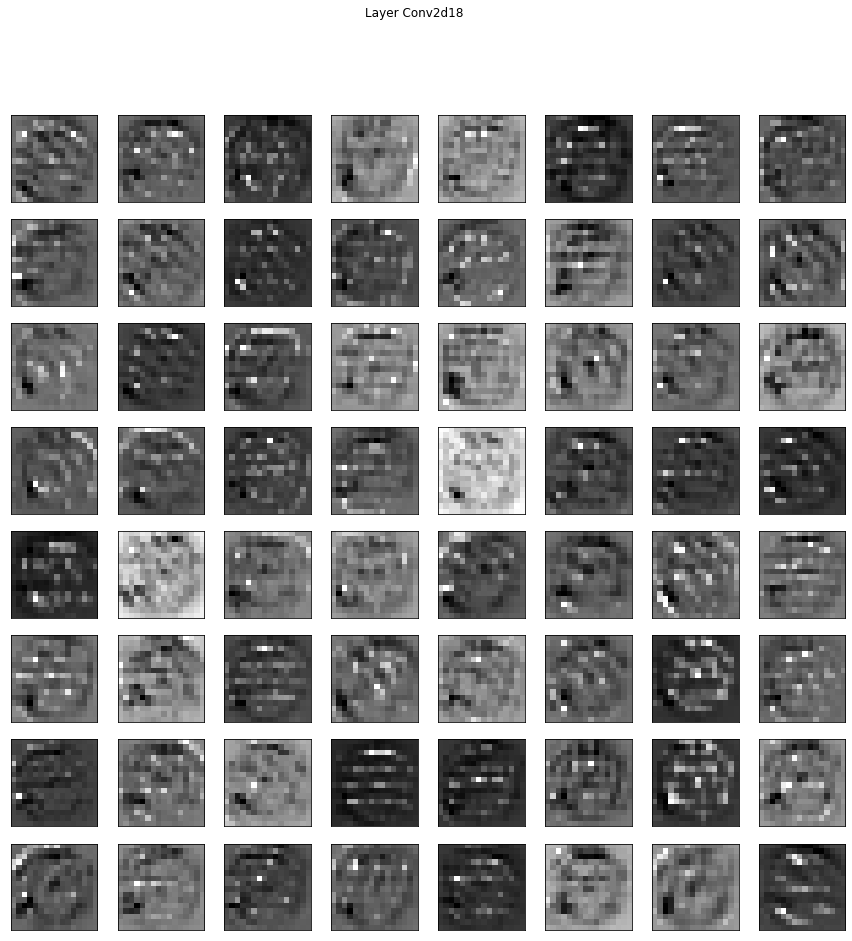

In [8]:
img = np.expand_dims(img_to_array(image), axis=0)
for i in idxs:
    model = tf.keras.models.Model(inputs=new_model.inputs, outputs=new_model.layers[i].output)

    feature_maps = model.predict(img)
    square = 8
    ix = 1
    skip = int(new_model.layers[2].output_shape[-1]/64)
    plt.figure(figsize = (15,15))
    plt.suptitle(f"Layer Conv2d{i}")
    for _ in range(0, square, skip):
        for _ in range(0, square, skip):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    
    plt.savefig(f"{new_model.layers[i].name}.png")
    plt.show()